# load tsai 库

In [1]:
from tsai.basics import *
import sktime
import sklearn

from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *

from sklearn.model_selection import train_test_split, ShuffleSplit
from scipy.io import loadmat
from sklearn import preprocessing
import matplotlib.pyplot as plt

from data_utils import get_data

# 数据导入与处理

In [2]:
train_data = loadmat('earthb.mat')
all_data = train_data['images']
all_target = train_data['labels']

In [ ]:
x.reshape(3, 2000)[0][:12]

In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test, splits, splits_test = get_data(all_data, all_target, dataset='eq')

In [ ]:
x_train.shape, x_valid.shape, x_test.shape

# 特征提取

In [ ]:
print("GPU/cuda or CPU?")
default_device()

In [ ]:
# (特征数， 序列长度) -> (1, 1500)
mrf = MiniRocketFeatures(x_train.shape[1], x_train.shape[2]).to(default_device())
mrf.fit(x_train)

In [ ]:
# 训练集与测试集， 索引见 splits
X = np.concatenate([x_train, x_valid])
y = np.concatenate([y_train, y_valid])

In [ ]:
X_feat = get_minirocket_features(X, mrf, chunksize=512, to_np=True)
X_feat.shape, type(X_feat)

# 在特征之上进行训练

In [ ]:
# As above, use tsai to bring X_feat into fastai, and train.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocketHead, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(50, 3e-4)
timer.stop()

# 验证

In [ ]:
new_feat = get_minirocket_features(X[splits[1]], mrf, chunksize=1024, to_np=True)
print(new_feat.shape, type(new_feat))
probas, _, preds = learn.get_X_preds(new_feat)
print(preds)
print("valid accuracy", sklearn.metrics.accuracy_score(y[splits[1]], preds.astype(int)))

# 保存模型

特征提取与模型learn 都要保存

learn.export 必须放在最后， 整个导出后， learn 不能用了， 必须重新读取

In [ ]:
PATH = Path("./models/MR_feature.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)
PATH = Path('./models/MR_learner.pkl')
learn.export(PATH)
print('model save path', PATH)

# 读取模型

In [ ]:
mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(default_device())
PATH = Path("./models/MR_feature.pt")
mrf.load_state_dict(torch.load(PATH))
PATH = Path('./models/MR_learner.pkl')
learn = load_learner(PATH, cpu=False)

In [ ]:
new_feat = get_minirocket_features(x_test, mrf, chunksize=1024, to_np=True)
probas, _, preds = learn.get_X_preds(new_feat)
print('Test accuracy', sklearn.metrics.accuracy_score(y_test, preds.astype(int)))

In [ ]:
preds = preds.astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test, preds)

In [ ]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0, 1, 2])
disp.plot()

In [ ]:
maps = {0: 'blast', 1:'noise', 2: 'earthq'}

In [ ]:
k=44
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
k=57
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
k=150 
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
index[k]

In [ ]:
splits_test[1][1157]

In [ ]:
plt.plot(np.arange(2000), all_data[20082][:2000])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
plt.plot(np.arange(1500), all_data[5694][300:1800])
plt.title('%d, pred=%s, y=%s' % (5694, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
k=44
plt.plot(np.arange(1500), x_test[k][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [ ]:
k=171
plt.plot(np.arange(1500), x_test[k][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [14]:
new_feat = get_minirocket_features(x_test, mrf, chunksize=1024, to_np=True)
probas, _, preds = learn.get_X_preds(new_feat)
print('Test accuracy', sklearn.metrics.accuracy_score(y_test, preds.astype(int)))

Test accuracy 0.9546279491833031


In [15]:
preds = preds.astype(int)

In [16]:
ttt = y_test - preds

In [17]:
index = np.where(ttt != 0)[0]

In [18]:
index.shape

(300,)

In [34]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

In [32]:
cm = confusion_matrix(y_test, preds)

In [35]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0, 1, 2])

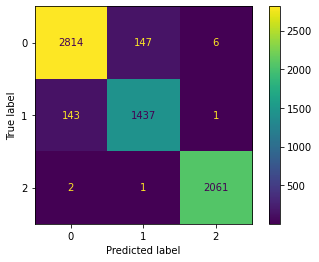

In [36]:
disp.plot()

In [19]:
index

array([  20,   43,   44,   50,   73,   92,  119,  167,  198,  205,  217,
        233,  240,  247,  286,  312,  317,  318,  320,  324,  325,  356,
        393,  405,  443,  452,  472,  481,  506,  522,  548,  570,  662,
        681,  683,  686,  689,  717,  738,  751,  788,  808,  814,  823,
        825,  842,  868,  911,  983, 1005, 1021, 1023, 1026, 1048, 1050,
       1072, 1145, 1157, 1180, 1209, 1229, 1249, 1250, 1292, 1301, 1319,
       1324, 1353, 1399, 1430, 1437, 1443, 1477, 1489, 1506, 1534, 1546,
       1550, 1615, 1620, 1633, 1648, 1658, 1706, 1736, 1803, 1823, 1824,
       1954, 1960, 1967, 2018, 2021, 2046, 2139, 2156, 2161, 2170, 2178,
       2209, 2211, 2224, 2227, 2229, 2251, 2294, 2316, 2348, 2364, 2365,
       2367, 2368, 2379, 2455, 2466, 2478, 2487, 2490, 2492, 2499, 2573,
       2621, 2636, 2685, 2708, 2714, 2738, 2739, 2778, 2793, 2811, 2812,
       2839, 2849, 2932, 2934, 2974, 3007, 3011, 3030, 3096, 3099, 3104,
       3124, 3148, 3153, 3162, 3187, 3205, 3239, 32

In [20]:
for i in range(10):
    print(index[i], preds[index[i]], y_test[index[i]])

20 0 1
43 0 1
44 1 0
50 0 1
73 0 1
92 0 2
119 0 1
167 1 0
198 0 1
205 0 1


In [29]:
for i in range(len(index)):
    if preds[index[i]] * y_test[index[i]] == 2:
        print(i, index[i], preds[index[i]], y_test[index[i]])

57 1157 2 1
150 3279 1 2


In [23]:
maps = {0: 'blast', 1:'noise', 2: 'earthq'}

Text(0.5, 1.0, '44, pred=blast, y=noise')

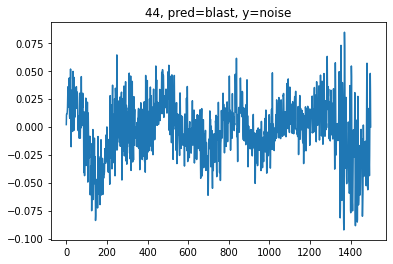

In [53]:
k=44
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

Text(0.5, 1.0, '57, pred=earthq, y=noise')

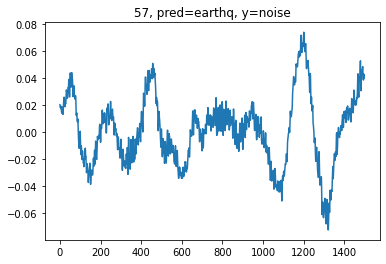

In [46]:
k=57
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

Text(0.5, 1.0, '150, pred=noise, y=earthq')

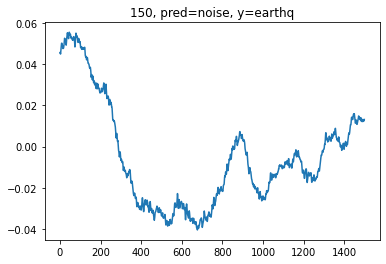

In [45]:
k=150 
plt.plot(np.arange(1500), x_test[index[k]][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

In [47]:
index[k]

1157

In [48]:
splits_test[1][1157]

5694

Text(0.5, 1.0, '57, pred=earthq, y=noise')

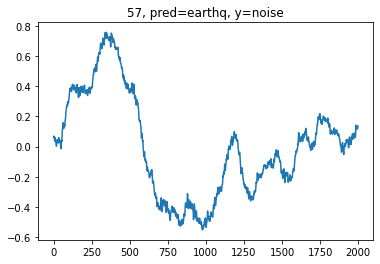

In [52]:
plt.plot(np.arange(2000), all_data[20082][:2000])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

Text(0.5, 1.0, '5694, pred=earthq, y=noise')

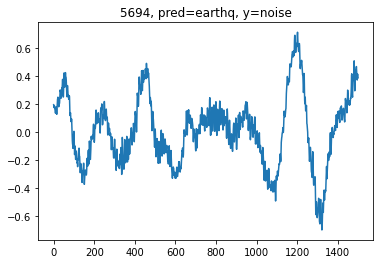

In [50]:
plt.plot(np.arange(1500), all_data[5694][300:1800])
plt.title('%d, pred=%s, y=%s' % (5694, maps[preds[index[k]]], maps[y_test[index[k]]]))

Text(0.5, 1.0, '44, pred=noise, y=blast')

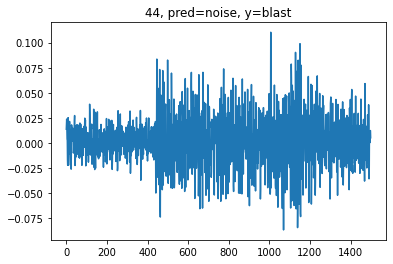

In [43]:
k=44
plt.plot(np.arange(1500), x_test[k][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))

Text(0.5, 1.0, '171, pred=blast, y=noise')

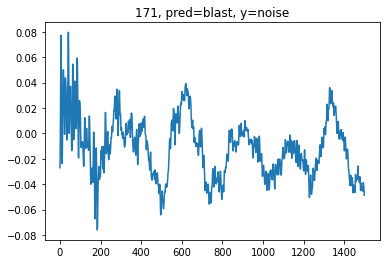

In [44]:
k=171
plt.plot(np.arange(1500), x_test[k][0])
plt.title('%d, pred=%s, y=%s' % (k, maps[preds[index[k]]], maps[y_test[index[k]]]))